# 16 Land cover statistics

## About the data

In this lesson we will use two datasets.

The first one is [GAP/LANDFIRE National Terrestrial Ecosystems data for 2011 @davidson_gaplandfire_2016](https://www.sciencebase.gov/catalog/item/573cc51be4b0dae0d5e4b0c5), from the [US Geological Survey (USGS)](https://www.usgs.gov). This is a categorical raster with a 30 m x 30 m pixel resolution representing highly thematically detailed land cover map of the U.S. We will access this data through the [Microsoft Planetary Computer (MPC) data catalog](https://planetarycomputer.microsoft.com/dataset/gap). The class names and corresponding codes have been saved to a separete CSV to simplify access in this lesson. Further information on how to access the classes directly from the data are available in the [MPC catalog](https://planetarycomputer.microsoft.com/dataset/gap#Example-Notebook).


The second dataset is a shapefile with the perimeters for 2017 California fires. This data was extracted from the CALFIRE's [Historical Wildland Fire Perimeters](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/about).

## Import auxiliary geometries

Let's start by importing the necessary libraries:

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image 

Then import and select the Thomas Fire within the fire perimeters data:

<Axes: >

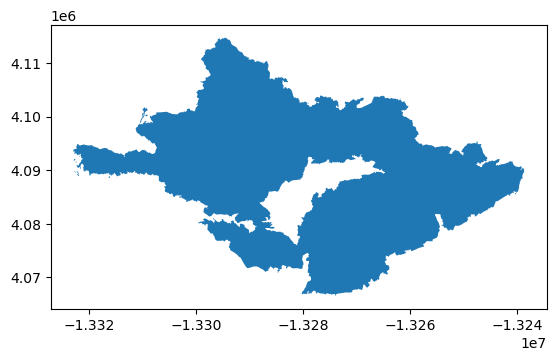

In [2]:
# UPDATE THIS AS NEEDED SO YOU CAN IMPORT THE DATA

fire_perimeters = gpd.read_file(os.path.join('data',
                  'California_Fire_Perimeters_2017',
                  'California_Fire_Perimeters_2017',
                  'California_Fire_Perimeters_2017.shp'
                 ))
thomas_fire = fire_perimeters[fire_perimeters['FIRE_NAME']=='THOMAS']

# Examine fire perimeter data
thomas_fire.crs
thomas_fire.plot()

And import the CA state perimeter:

<Axes: >

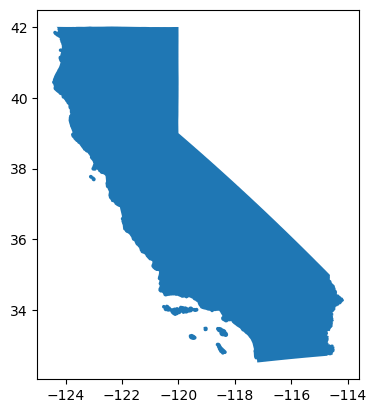

In [3]:
# UPDATE THIS AS NEEDED SO YOU CAN IMPORT THE DATA
ca = gpd.read_file(os.path.join('data',
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))
ca.plot()

## Catalog search

Our goal is to retrieve the National Terrestrial Ecosystems data over the fire perimeter. In the [last lesson](/book/chapters/lesson-16-STAC.qmd) we used GeoJSON-type dictionary to do the catalog search. Here we will use a list `[xmin, ymin, xmax, ymax]` with the coordinate values defining the four corners of the region we want to search data over. Just as the GeoJSON, these coordinates have to be in the EPSG:4326 CRS. 

Our bounding box will come from the Thomas Fire perimeter. Notice we use method chaining to reproject and extract the bounds.

In [4]:
# Create list of bounding box coords for search in 4326 CRS
thomas_fire_bbox = list(thomas_fire.to_crs('epsg:4326') 
                                   .total_bounds
                                    )
thomas_fire_bbox

[-119.68162520650904,
 34.27989979600195,
 -118.92518097019486,
 34.63745683414112]

Next, we connect to the Microsoft Planetary Computer data catalog and perform the search. The collection ID for the National Terrestrial Ecosystems data is `gap`:

In [5]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog 
search = catalog.search(collections=['gap'], 
                        bbox=thomas_fire_bbox)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 1 Items


There is a single item in the search, so let’s go ahead and select it and view its pre-rendered image:

In [6]:
# Select unique search item
item = items[0]  

# Display pre-rendered image
Image(url=item.assets['rendered_preview'].href, width=600)

We can see this is a big raster!

At this point, we can also import the CSV file with the class labels:

In [7]:
labels = pd.read_csv(os.path.join('data',
                                  'GAP_National_Terrestrial_Ecosystems.csv')
                                  )
labels.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


## Explore raster
Next, we can go ahead an open the raster:

In [8]:
# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)
lulc

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int32 4B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

Notice that band is a dimension of length 1. We can go ahead and “squeeze” the raster to simplify it:

In [9]:
# Remove length 1 dimension (band)
lulc = lulc.squeeze().drop_vars('band')
print("Sizes of dimensions:", dict(lulc.sizes))

Sizes of dimensions: {'y': 10000, 'x': 10000}


Next, let’s look at how the raster is locatd with respect to the Thomas Fire perimeter and the CA state boundary:

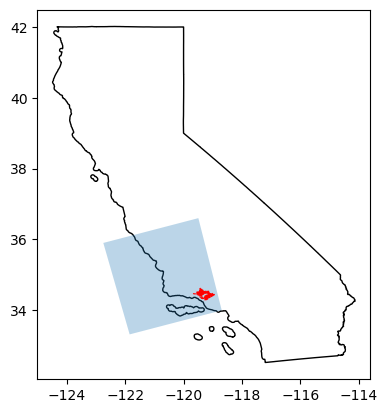

In [10]:
# Create GeoDataFrame from raster bounding box
lulc_bbox = gpd.GeoDataFrame(geometry = [box(*lulc.rio.bounds())],
                             crs = lulc.rio.crs)

ca = gpd.read_file(os.path.join('data',
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))

# ------------------------------------------------------------------
# Plot raster boundary, fire perimeter, and CA boundary
fig, ax = plt.subplots()
ca.plot(ax=ax, color='white', edgecolor ='black')

# Reproject lulc_bbox and fire perimeter to match CA crs
lulc_bbox.to_crs(ca.crs).plot(ax=ax, alpha=0.3)  
thomas_fire.to_crs(ca.crs).plot(ax=ax, color='red')

plt.show()

We can see the raster covers a big area relative to the fire perimeter. Since we want to calculate the land coverage statistics within the fire perimeter, we will have to clip the raster to this area.

## Clip raster to geometry
In our first lesson about rasters we saw how to clip a raster to a rectangular region. In our case, we want to clip the raster exactly to the fire perimeter. Clipping can be a costly operation for such a big raster relative to a detailed geometry. So we will perform the clipping in two steps:

Clip the raster using the fire perimeter bounding box using `rio.clip_box()` and then
Clip the simplified raster to the fire perimeter using `rio.clip()`.

c:\Users\Melannie\.conda\envs\eds220-env\Lib\site-packages\xarray\core\duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


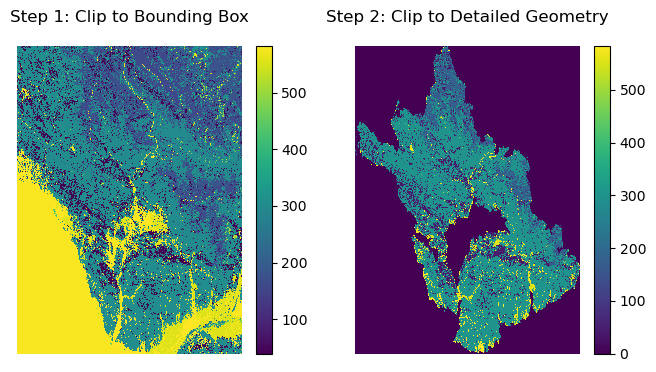

In [11]:
# Match CRSs and verify update
thomas_fire_match = thomas_fire.to_crs(lulc.rio.crs)
assert thomas_fire_match.crs == lulc.rio.crs

# Clip large raster to detailed geometry in two steps
lulc_step1 = lulc.rio.clip_box(*thomas_fire_match.total_bounds)
lulc_step2 = lulc_step1.rio.clip(thomas_fire_match.geometry)  # Produces RuntimeWarning

# ------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first clipped raster
lulc_step1.plot(ax=ax[0])
ax[0].set_title("Step 1: Clip to Bounding Box")
ax[0].axis("off")

# Plot the second clipped raster
lulc_step2.plot(ax=ax[1])
ax[1].set_title("Step 2: Clip to Detailed Geometry")
ax[1].axis("off")

plt.show()

## Raster no-data values
Notice a warning appeared when we clipped the raster. After some investigation, we will find that this RuntimeWarning occurs because the rio.clip() function tries to replace values outside the fire perimeter geometry with np.nan. However, as we previously saw, our raster’s data type is uint16 (16 bits unsigned integer). The cast issue appears since np.nan is a float (decimal number) and it cannot be casted as a uint16. To make sure the clipping function fills in any pixels with the adequate no-data value, let’s manually set it:

In [12]:
print('Original no-data value: ', lulc.rio.nodata)

# Update raster's no-data value
lulc = lulc.rio.write_nodata(0)
print('Updated no-data value: ', lulc.rio.nodata)

Original no-data value:  None
Updated no-data value:  0


This way, the `rio.clip()` function will know what values to assign to pixels outside the fire perimeter. Let’s try clipping again, this time using method chaining:

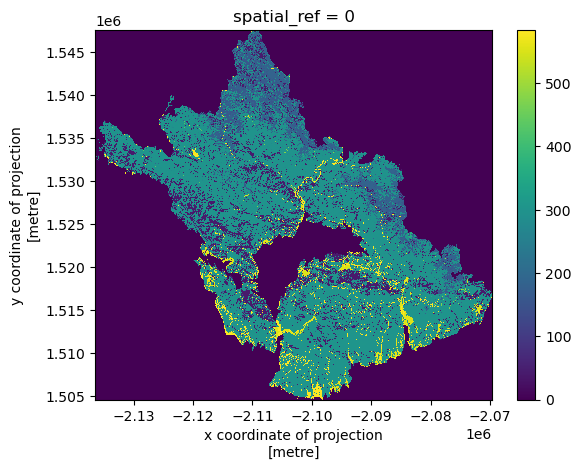

In [13]:
lulc_clip = (lulc.rio.clip_box(*thomas_fire_match.total_bounds)
                 .rio.clip(thomas_fire_match.geometry)
                 )

# Examine results
lulc_clip.plot()                                  

Notice no warning came up during the clipping!


#### Always pay attention to warnings!
Warnings are your program’s way of saying, “Something might go wrong here, take a look!” They may indicate silent failures, package compatibility issues, or potential bugs, amont other issues. Do not ignore warnings! Addressing warnings is part of writing clean, maintainable code and reflects a professional approach.

These are some steps to handling warnings effectively:

Read and understand them: Don’t dismiss warnings without understanding their cause.
Fix or address them: Modify your code to resolve the warning if possible.
Suppress only when necessary: Use tools to suppress warnings only when you’re sure they are irrelevant or benign.


## Land cover statistics
In the rest of this lesson we will calculate land cover statistics within the Thomas Fire perimeter. The following exercises will guide you through this process:

#### Exercises
1. Use the numpy function np.unique() to get the number of pixels per class in lulc_clip. HINT: check the np.unique() documentation to see what the return_counts parameter does and read the last example.

2. Create a data frame pix_counts with two columns: column one must be the code numbers for the pixels in lulc_clip and column two must be the number of pixels corresponding to each code. HINT: check our class notes on pandas.DataFrames

3. Use the labels data frame to add the class names to the codes in the pix_counts data frame. Store the resulting data frame as classes.

4. What area within the fire perimeter (in km^2) was estimated to be developed? HINT: what is the raster’s resolution?

5. Store the total number of pixels within the fire perimeter as a variable total_pixels.

6. Add the percentage of area covered by each class as a new column percentage to the classes data frame. Sort the data frame by percentage coverage in descending order.

7. Create a horizontal bar plot showing the classes with more than 1% land cover in decreasing order. For example:

In [18]:
#1. Get the number of pixels per class
s = pd.Series(np.unique(lulc_clip, return_counts = True))

In [19]:
#2.
d = {'code' : pd.Series(s[0]),
'count' : pd.Series(s[1])
}

pix_counts = pd.DataFrame(d)

In [20]:
pix_counts

,code,count
0,0,1927870
1,39,6856
2,40,361
3,41,133704
4,42,3638
5,43,23150
6,45,2907
7,55,4974
8,159,3727
9,162,60203


In [22]:
?pd.merge

Signature:
pd.merge(
    left: 'DataFrame | Series',
    right: 'DataFrame | Series',
    how: 'MergeHow' = 'inner',
    on: 'IndexLabel | AnyArrayLike | None' = None,
    left_on: 'IndexLabel | AnyArrayLike | None' = None,
    right_on: 'IndexLabel | AnyArrayLike | None' = None,
    left_index: 'bool' = False,
    right_index: 'bool' = False,
    sort: 'bool' = False,
    suffixes: 'Suffixes' = ('_x', '_y'),
    copy: 'bool | None' = None,
    indicator: 'str | bool' = False,
    validate: 'str | None' = None,
) -> 'DataFrame'
Docstring:
Merge DataFrame or named Series objects with a database-style join.

A named Series object is treated as a DataFrame with a single named column.

The join is done on columns or indexes. If joining columns on
columns, the DataFrame indexes *will be ignored*. Otherwise if joining indexes
on indexes or indexes on a column or columns, the index will be passed on.
When performing a cross merge, no column specifications to merge on are
allowed.

.. warning:

In [24]:
#3. 
classes = pd.merge(labels, pix_counts,
                   how = 'left',
                   on = 'code')
classes

,class_label,code,count
0,0,0,1927870.0
1,South Florida Bayhead Swamp,1,NaN
2,South Florida Cypress Dome,2,NaN
3,South Florida Dwarf Cypress Savanna,3,NaN
4,South Florida Mangrove Swamp,4,NaN
...,...,...,...
580,"Quarries, Mines, Gravel Pits and Oil Wells",580,NaN
581,"Developed, Open Space",581,40653.0
582,"Developed, Low Intensity",582,3782.0
583,"Developed, Medium Intensity",583,829.0


#### Bonus Exercise
In this lesson we used a CSV with the class labels for the GAP/LANDFIRE National Terrestrial Ecosystems data. However, this information is stored in the properties for the STAC item we worked with.

Access the labels for the item and used them to recreate the labels pandas.DataFrame we imported from the CSV.